# Preparing the Dataset

In [205]:
import prepare_data
import pandas as pd
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import ast

In [232]:
def load_df(path,list_cols):
    df = pd.read_csv(path,sep="|")
    df[list_cols] = df[list_cols].applymap(
    lambda x: ast.literal_eval(x))
    return df

In [281]:
def save_df(df,path):
    df.to_csv(path,index=False,sep="|")

In [279]:
def tokenize_pos_tagging(df):
    #Tokenize the sentences
    df[[s_sent_col,n_sent_col]] = df[[s_sent_col,n_sent_col]].applymap(lambda x: nltk.word_tokenize(x))
    
    #Filter out sentences with no english word
    #df = df.loc[df[n_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) > 0]
    #df = df.loc[df[s_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) > 0]
    
    #POS Tagging of sentences
    df[[s_sent_col,n_sent_col]] = df[[s_sent_col,n_sent_col]].applymap(lambda x: list(zip(*nltk.pos_tag(x))))
    
    #Divide created column into word and tag part
    df["s_sent"] = df[[s_sent_col]].apply(lambda x: x[s_sent_col][0],axis=1)
    df["s_pos"] = df[[s_sent_col]].apply(lambda x: x[s_sent_col][1],axis=1)
    df["n_sent"] = df[[n_sent_col]].apply(lambda x: x[n_sent_col][0],axis=1)
    df["n_pos"] = df[[n_sent_col]].apply(lambda x: x[n_sent_col][1],axis=1)
    
    #Drop previous columns
    df = df.drop([s_sent_col,n_sent_col],axis=1)
    
    return df

In [122]:
simple_path = "data/simple.aligned"
normal_path = "data/normal.aligned"

In [227]:
s_sent_col = "simple_sentence"
n_sent_col = "normal_sentence"

s_list_col = "s_sent"
s_pos_col = "s_pos"
n_list_col = "n_sent"
n_pos_col = "n_pos"
s_lem_col = "s_lem"
n_lem_col = "n_lem"

In [280]:
aligned_data = list(prepare_data.get_aligned_sentences(simple_path,normal_path))
df = prepare_data.create_df(aligned_data)
pos_df = tokenize_pos_tagging(df)

In [282]:
#Save Corpus to file
save_df(pos_df,"data/wikipedia_aligned_pos.csv")

# Lemmatizing

In [283]:
 def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [284]:
lemmatizer = WordNetLemmatizer()

In [285]:
df = pos_df.copy()

In [286]:
s_lemmatized = df.apply(
    lambda x: [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) 
               for word,tag in zip(*[x[s_list_col],x[s_pos_col]])],axis=1)
n_lemmatized = df.apply(
    lambda x: [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) 
               for word,tag in zip(*[x[s_list_col],x[s_pos_col]])],axis=1)

df[s_lem_col] = s_lemmatized
df[n_lem_col] = n_lemmatized

In [242]:
#df = df.drop([s_list_col,n_list_col],axis=1)
df.to_csv("data/wikipedia_aligned_lem.csv",index=False,sep="|")

# Feature Implementation

In [233]:
df = load_df("data/wikipedia_aligned_lem.csv",[s_lem_col,n_lem_col,s_pos_col,n_pos_col])

In [234]:
df.head()

,simple_numb,normal_topic,normal_numb,s_sent,s_pos,n_sent,n_pos,s_lem,n_lem
0,0,"cherokee, oklahoma",0,"('cherokee', 'is', 'a', 'city', 'of', 'oklahom...","(NN, VBZ, DT, NN, IN, NN, IN, DT, JJ, NNS, .)","('cherokee', 'is', 'a', 'city', 'in', 'alfalfa...","(NN, VBZ, DT, NN, IN, JJ, NN, ,, NN, ,, JJ, NN...","[cherokee, be, a, city, of, oklahoma, in, the,...","[cherokee, be, a, city, in, alfalfa, county, ,..."
1,2,skateboard,5,"('skateboard', 'decks', 'are', 'normally', 'be...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","('skateboard', 'decks', 'are', 'usually', 'bet...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","[skateboard, deck, be, normally, between, 28, ...","[skateboard, deck, be, usually, between, 28, a..."
2,2,skateboard,5,"('the', 'bottom', 'of', 'the', 'deck', 'can', ...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","('the', 'underside', 'of', 'the', 'deck', 'can...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","[the, bottom, of, the, deck, can, be, print, w...","[the, underside, of, the, deck, can, be, print..."
3,3,skateboard,6,"('the', 'longboard', 'was', 'made', 'by', 'two...","(DT, NN, VBD, VBN, IN, CD, NNS, :, CC, NN, CC,...","('this', 'was', 'created', 'by', 'two', 'surfe...","(DT, VBD, VBN, IN, CD, NNS, :, CC, NN, CC, JJ,...","[the, longboard, be, make, by, two, surfer, ;,...","[this, be, create, by, two, surfer, ;, ben, wh..."
4,2,skateboard,5,"('other', 'materials', 'used', 'in', 'making',...","(JJ, NNS, VBN, IN, VBG, NNS, NN, ,, NN, ,, NN,...","('some', 'of', 'them', 'have', 'special', 'mat...","(DT, IN, PRP, VBP, JJ, NNS, WDT, VBP, TO, VB, ...","[other, material, use, in, make, deck, fibergl...","[some, of, them, have, special, material, that..."


## Word and Sentence Length

In [243]:
def count_sent_word_length(df):
    len_mean_sents = df[[s_lem_col,n_lem_col]].applymap(lambda x: (len(x),np.mean([len(word) for word in x])))
    df[['s_sent_len', 's_word_mean']] = len_mean_sents[s_lem_col].apply(pd.Series)
    df[['n_sent_len', 'n_word_mean']] = len_mean_sents[n_lem_col].apply(pd.Series)
    return df

In [244]:
df = count_sent_word_length(df)

In [245]:
df.head()

,simple_numb,normal_topic,normal_numb,s_pos,n_pos,s_lem,n_lem,s_sent_len,s_word_mean,n_sent_len,n_word_mean
0,0,"cherokee, oklahoma",0,"(NN, VBZ, DT, NN, IN, NN, IN, DT, JJ, NNS, .)","(NN, VBZ, DT, NN, IN, JJ, NN, ,, NN, ,, JJ, NN...","[cherokee, be, a, city, of, oklahoma, in, the,...","[cherokee, be, a, city, in, alfalfa, county, ,...",11.0,3.818182,13.0,4.000000
1,2,skateboard,5,"(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","[skateboard, deck, be, normally, between, 28, ...","[skateboard, deck, be, usually, between, 28, a...",11.0,4.272727,11.0,4.181818
2,2,skateboard,5,"(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","[the, bottom, of, the, deck, can, be, print, w...","[the, underside, of, the, deck, can, be, print...",21.0,3.095238,24.0,3.791667
3,3,skateboard,6,"(DT, NN, VBD, VBN, IN, CD, NNS, :, CC, NN, CC,...","(DT, VBD, VBN, IN, CD, NNS, :, CC, NN, CC, JJ,...","[the, longboard, be, make, by, two, surfer, ;,...","[this, be, create, by, two, surfer, ;, ben, wh...",14.0,4.000000,13.0,3.846154
4,2,skateboard,5,"(JJ, NNS, VBN, IN, VBG, NNS, NN, ,, NN, ,, NN,...","(DT, IN, PRP, VBP, JJ, NNS, WDT, VBP, TO, VB, ...","[other, material, use, in, make, deck, fibergl...","[some, of, them, have, special, material, that...",22.0,4.045455,33.0,3.878788


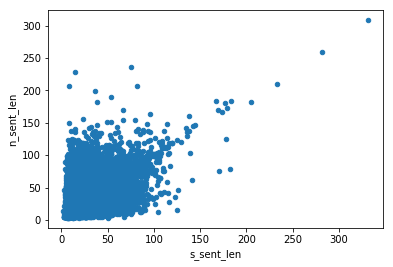

In [246]:
df.plot.scatter(x="s_sent_len",y="n_sent_len")

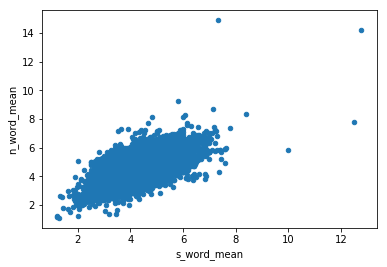

In [247]:
df.plot.scatter(x="s_word_mean",y="n_word_mean")

## Basic English

In [248]:
with open("data/basic_english.txt","r") as f:
    data = f.read()
    words = data.split(" , ")
    basic_df = pd.DataFrame(data=words,columns=["word"])
    basic_df["index"] = range(0,len(basic_df))
basic_df.head()

,word,index
0,a,0
1,able,1
2,about,2
3,account,3
4,acid,4


## Top 20k English Words

In [249]:
with open("data/20k_words.txt","r") as f:
    data = f.read()
    words = data.split("\n")
    english_df = pd.DataFrame(data=words,columns=["word"])
    english_df["index"] = range(0,len(english_df))
    non_basic_df = english_df.loc[~english_df["word"].isin(basic_df["word"])]
non_basic_df.head(10)

,word,index
7,is,7
10,by,10
13,i,13
15,it,15
18,be,18
19,are,19
23,your,23
27,more,27
28,an,28
29,was,29


## Ratio between Basic and Non-Basic English Words

In [254]:
#how many words are not in the basic english
df[["s_non_basic_freq","n_non_basic_freq"]] = df[[s_lem_col,n_lem_col]].applymap(
    lambda x: len(set(x).intersection(
        non_basic_df["word"].values))/len(set(x).intersection(
        english_df["word"].values)))

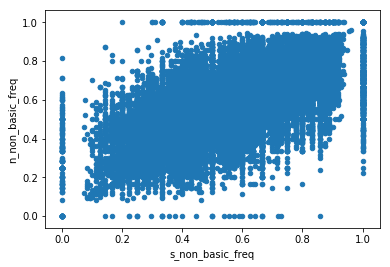

In [257]:
df.plot.scatter(x="s_non_basic_freq",y="n_non_basic_freq")

In [270]:
df.loc[
    (df["s_non_basic_freq"] < 0.1)
    | (df["s_non_basic_freq"] > 0.95) 
    | (df["n_non_basic_freq"] < 0.1) 
    | (df["n_non_basic_freq"] > 0.95)]

,simple_numb,normal_topic,normal_numb,s_pos,n_pos,s_lem,n_lem,s_sent_len,s_word_mean,n_sent_len,n_word_mean,s_non_basic_freq,n_non_basic_freq
24,1,chenab river,0,"(DT, NN, RB, VBZ, DT, NN, IN, NN, .)","(DT, NN, RB, VBZ, DT, NN, IN, NN, ,, NN, .)","[the, chenab, then, join, the, indus, at, mith...","[the, chenab, then, join, the, indus, at, mith...",9.0,4.111111,11.0,4.181818,0.000000,0.200000
49,14,"king's college, cambridge",16,"(DT, NN, CC, NN, NNS, IN, DT, NN, IN, DT, NN, .)","(DT, NN, CC, NN, NNS, IN, DT, NN, IN, DT, NN, ...","[a, hammer, and, sickle, survives, in, a, fram...","[a, hammer, and, sickle, survives, in, a, fram...",12.0,3.500000,18.0,3.722222,0.000000,0.166667
284,16,united states secretary of the army,27,"(RB, CD, ,, CD, :, NN, CD, ,, CD, NN, NN)","(RB, CD, ,, CD, IN, ``, MD, CD, ,, CD, NN, NN)","[november, 22, ,, 1993, -, december, 2, ,, 199...","[november, 22, ,, 1993, â, ``, may, 4, ,, 1997...",11.0,3.727273,12.0,3.166667,1.000000,0.750000
285,13,united states secretary of the army,21,"(JJ, CD, ,, CD, :, JJ, CD, ,, CD, NN, NN)","(JJ, CD, ,, CD, NN, ``, JJ, CD, ,, CD, NN, NN)","[february, 14, ,, 1977, -, january, 20, ,, 198...","[february, 14, ,, 1977, â, ``, january, 20, ,,...",11.0,3.727273,12.0,3.583333,1.000000,1.000000
286,2,united states secretary of the army,8,"(NN, JJ, NN, CD, ,, CD, :, NN, CD, ,, CD, NN, ...","(NN, JJ, NN, CD, ,, CD, NN, ``, JJ, CD, ,, CD,...","[gordon, gray, june, 20, ,, 1949, -, april, 12...","[gordon, gray, april, 28, ,, 1949, â, ``, apri...",14.0,3.357143,15.0,3.333333,1.000000,1.000000
287,17,united states secretary of the army,28,"(NN, NN, NN, VBD, CD, ,, CD, :, NN, CD, ,, CD,...","(NN, NN, NN, NNP, VBG, NNP, NN, CD, ,, CD, NN,...","[robert, m., walker, december, 2, ,, 1997, -, ...","[robert, m., walker, -lrb-, act, -rrb-, decemb...",14.0,3.571429,18.0,3.611111,1.000000,0.857143
289,9,united states secretary of the army,16,"(NN, NN, NN, NN, CD, ,, CD, :, NN, CD, ,, CD, ...","(NN, NN, NN, NN, CD, ,, CD, NN, ``, JJ, CD, ,,...","[stanley, r., resor, july, 2, ,, 1965, -, june...","[stanley, r., resor, july, 2, ,, 1965, â, ``, ...",18.0,3.555556,19.0,3.473684,1.000000,1.000000
290,7,united states secretary of the army,14,"(NN, NNS, NN, RB, CD, ,, CD, :, JJ, CD, ,, CD,...","(NN, NNS, NN, RB, CD, ,, CD, NN, ``, JJ, CD, ,...","[cyrus, robert, vance, july, 5, ,, 1962, -, ja...","[cyrus, robert, vance, july, 5, ,, 1962, â, ``...",19.0,3.684211,20.0,3.600000,1.000000,1.000000
292,5,united states secretary of the army,12,"(JJ, NN, NN, NN, CD, ,, CD, :, JJ, CD, ,, CD, ...","(JJ, NN, NN, NN, CD, ,, CD, NN, ``, JJ, CD, ,,...","[wilber, marion, brucker, july, 21, ,, 1955, -...","[wilber, marion, brucker, july, 21, ,, 1955, â...",15.0,4.200000,16.0,4.062500,1.000000,1.000000
293,1,united states secretary of the army,7,"(NNS, VBP, JJ, NN, CD, ,, CD, :, NN, CD, ,, CD...","(NNS, VBP, JJ, NN, CD, ,, CD, NN, ``, JJ, CD, ...","[kenneth, claiborne, royall, september, 18, ,,...","[kenneth, claiborne, royall, september, 18, ,,...",15.0,4.266667,16.0,4.125000,1.000000,1.000000


In [278]:
df.to_csv("data/wikipedia_aligned_lem_V1.csv",sep="|",index=False)

## POS Tags

In [ ]:
#number of nouns
def get_numb_of_nouns(df):
    df[["s_pos_nouns","n_pos_nouns"]] = df[[s_pos_col,n_pos_col]].applymap(lambda x: )
#number of conjunctions
#number of pronouns